#Import Libraries & Loading the data


In [1]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

Load data from CSV

In [5]:
bank_data = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape')

convert the string date field to datetime

In [6]:
bank_data['InvoiceDate'] = pd.to_datetime(bank_data['InvoiceDate'])

we will be using France's data

In [7]:
france_bank_data = bank_data.query("Country =='France'").reset_index(drop=True)

# Calculating the Recency Score

we create a generic user dataframe to keep customerID and new segmentation scores

In [17]:
user_data = pd.DataFrame(france_bank_data['CustomerID'].unique())
user_data.columns = ['CustomerID']

get the max purchase date for each customer and create a dataframe with it

In [18]:
maxDate_data = france_bank_data.groupby('CustomerID').InvoiceDate.max().reset_index()
maxDate_data.columns = ['CustomerID','MaxPurchaseDate']

we take our observation point as the max invoice date in our dataset

In [19]:
maxDate_data['Recency'] = (maxDate_data['MaxPurchaseDate'].max() - maxDate_data['MaxPurchaseDate']).dt.days


merge this dataframe to our new user dataframe

In [20]:
user_data = pd.merge(user_data, maxDate_data[['CustomerID','Recency']], on='CustomerID')

In [21]:
user_data.head()


,CustomerID,Recency
0,12583.0,0
1,12686.0,353
2,12682.0,2
3,12567.0,4
4,12681.0,3


plot a recency histogram

In [22]:
plot_data = [
    go.Histogram(
        x=user_data['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


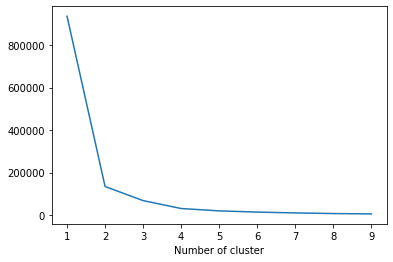

In [23]:
from sklearn.cluster import KMeans

sse={}
tx_recency = user_data[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

build 4 clusters for recency and add it to dataframe

In [24]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_data[['Recency']])
user_data['RecencyCluster'] = kmeans.predict(user_data[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

user_data = order_cluster('RecencyCluster', 'Recency',user_data,False)

In [25]:
user_data.head(100)

,CustomerID,Recency,RecencyCluster
0,12583.0,0,3
1,12682.0,2,3
2,12567.0,4,3
3,12681.0,3,3
4,12721.0,12,3
...,...,...,...
80,12506.0,214,1
81,12573.0,208,1
82,12690.0,187,1
83,12493.0,147,1


#Calculating the Frequency Score
To create frequency clusters, we need to find total number orders for each customer

get order counts for each user and create a dataframe with it

In [26]:
frequency_data = france_bank_data.groupby('CustomerID').InvoiceDate.count().reset_index()
frequency_data.columns = ['CustomerID','Frequency']

add this data to our main dataframe

In [27]:
user_data = pd.merge(user_data, frequency_data, on ='CustomerID')

plot the histogram

In [28]:
plot_data = [
    go.Histogram(
        x=user_data.query('Frequency<1000')['Frequency']
    )
]

plot_layour = go.Layout(
    title = 'Frequency'
)

fig2 = go.Figure(data=plot_data, layout = plot_layour)
pyoff.iplot(fig2)

k-means

In [29]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_data[['Frequency']])
user_data['FrequencyCluster'] = kmeans.predict(user_data[['Frequency']])

#order the frequency cluster
user_data = order_cluster('FrequencyCluster', 'Frequency',user_data,True)

#see details of each cluster
user_data.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,56.0,30.767857,17.665571,4.0,16.00,28.5,40.50,72.0
1,16.0,119.375000,28.770065,80.0,99.00,112.5,146.50,167.0
2,9.0,230.555556,49.112399,184.0,191.00,212.0,262.00,327.0
3,4.0,489.500000,99.841541,394.0,445.75,467.0,510.75,630.0


#Calculating the Revenue Score

calculate revenue for each customer

In [30]:
france_bank_data['Revenue']= france_bank_data['UnitPrice']*france_bank_data['Quantity']
revenue_data = france_bank_data.groupby('CustomerID').Revenue.sum().reset_index()

merge it with our main dataframe

In [31]:
user_data = pd.merge(user_data, revenue_data, on = 'CustomerID')

plot the histogram

In [32]:
plot_data = [
    go.Histogram(
        x=user_data.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig3 = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig3)

apply clustering

In [33]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_data[['Revenue']])
user_data['RevenueCluster'] = kmeans.predict(user_data[['Revenue']])


#order the cluster numbers
user_data = order_cluster('RevenueCluster', 'Revenue',user_data,True)

#show details of the dataframe
user_data.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,60.0,610.967667,438.904107,73.50,252.3225,508.305,826.4600,1922.26
1,19.0,3513.910000,1192.007897,2104.23,2733.9050,3344.640,3934.4750,6492.57
2,4.0,10138.637500,2413.663008,7423.61,8692.1075,10052.925,11499.4550,13025.09
3,2.0,18190.835000,852.169737,17588.26,17889.5475,18190.835,18492.1225,18793.41


#Overall Score

calculate overall score and use mean() to see details

In [34]:
user_data['OverallScore'] = user_data['RecencyCluster'] + user_data['FrequencyCluster'] + user_data['RevenueCluster']
user_data.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Revenue
OverallScore,,,
0,310.416667,17.083333,331.199167
1,193.000000,20.500000,288.833333
2,65.173913,36.652174,607.200870
3,20.312500,40.875000,886.182500
4,25.600000,109.600000,1891.094000
5,17.636364,136.000000,2815.850909
6,14.333333,243.666667,4856.765000
7,20.000000,247.000000,12505.935000
8,3.250000,460.250000,12981.087500


To keep things simple, better we name these scores:

0 to 2: Low Value

3 to 4: Mid Value

5+: High Value

In [35]:
user_data['Segment'] = 'Low-Value'
user_data.loc[user_data['OverallScore']>2,'Segment'] = 'Mid-Value' 
user_data.loc[user_data['OverallScore']>4,'Segment'] = 'High-Value' 

Revenue vs Frequency

In [36]:
tx_graph = user_data.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig4 = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig4)


Revenue vs. Recency

In [37]:
tx_graph = user_data.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)



Revenue vs. Frequency

In [38]:

tx_graph = user_data.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)